# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from pathlib import Path

import yaml
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_tile_metadata, nd2_to_tiff
from lib.preprocess.file_utils import get_sample_fps

## SET PARAMETERS

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "analysis_root/"

## SET PARAMETERS

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.
- `SBS_SAMPLE_PATTERN`/`PHENOTYPE_SAMPLE_PATTERN`: Regex patterns to match SBS/phenotype sample nd2 files. Matching groups correspond to metadata defined below.
- `SBS_METADATA`/`PHENOTYPE_METADATA`: List of metadata to extract from file name in order of appearance. Metadata corresponds to regex groups defined above:
    - For `SBS_METADATA`, commonly set to `["cycle", "well", "tile"]`. 
    - For `PHENOTYPE_METADATA`, commonly set to `["well", "tile"]`. 
    - For images that are saved as one channel per ND2 file, or if there are multiple rounds of phenotype images, use `["well", "tile", "channel"]`.


*Notes: 
- Paths can be absolute or relative to where workflows are run from.
- Each SBS/phenotype pattern should have the same number of groups as pieces of metadata. Metadata should be listed in the same order that it appears in the regex pattern.

In [3]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# Directory, pattern, and metadata for SBS sample nd2 files
SBS_IMAGES_DIR_FP = Path("data/sbs/")
SBS_SAMPLE_PATTERN = r"C(\d+)_Wells-([A-Z]\d+)_Points-(\d+)"
SBS_METADATA = ["cycle", "well", "tile"]

# Directory, pattern, and metadata for phenotype sample nd2 files
PHENOTYPE_IMAGES_DIR_FP = Path("data/phenotype/")
PHENOTYPE_SAMPLE_PATTERN = r"Wells-([A-Z]\d+)_Points-(\d+)"
PHENOTYPE_METADATA = ["well", "tile"]

You must supply a working regex to the _PATTERN variables. If you don't have experience with regex, you can use the following LLM prompt to generate the example sample patterns.

_Enter into a basic LLM chatbot_: Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example filenames:
[ENTER YOUR EXAMPLE FILES HERE]

Required regex patterns (return these exact variable assignments):

SBS_SAMPLE_PATTERN = r"..."
PHENOTYPE_SAMPLE_PATTERN = r"..."
SBS_CHANNEL_PATTERN = r"..." 
PHENOTYPE_CHANNEL_PATTERN = r"..."

The patterns should extract:

1. SBS_SAMPLE_PATTERN:
  - Cycle number (after "C")
  - Well ID (after "Wells-")  
  - Tile number (after "Points-")
  - Channel name (between "Channel_" and next "_" or "."). Don't include if images are multichannel.

2. PHENOTYPE_SAMPLE_PATTERN:
  - Well ID (after "Wells-")
  - Tile number (after "Points-") 
  - Channel name (between "Channel_" and next "_" or "."). Don't include if images are multichannel.

The patterns will be used like this:
```python
# Sample pattern matching
match = re.search(SBS_SAMPLE_PATTERN, filename)
cycle = int(match.group(1))
well = match.group(2) 
tile = int(match.group(3))
# Channel pattern matching (if image is not multichannel)
channel = match.group(4)
```

## Create Sample DFs

## Test Metadata Extraction

In [4]:
# Create sample dataframe for SBS
sbs_samples = create_samples_df(SBS_IMAGES_DIR_FP, SBS_SAMPLE_PATTERN, SBS_METADATA)
# Save and display sample dataframe
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create sample dataframe for phenotype
phenotype_samples = create_samples_df(
    PHENOTYPE_IMAGES_DIR_FP, PHENOTYPE_SAMPLE_PATTERN, PHENOTYPE_METADATA
)
# Save and display sample dataframe
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

SBS samples:


,sample_fp,cycle,well,tile
0,data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_...,1,A1,1
1,data/sbs/empty_images/P001_SBS_10x_C1_Wells-A1...,1,A1,2
2,data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_...,1,A1,100
3,data/sbs/real_images/P001_SBS_10x_C1_Wells-A2_...,1,A2,1
4,data/sbs/empty_images/P001_SBS_10x_C1_Wells-A2...,1,A2,2
...,...,...,...,...
61,data/sbs/empty_images/P001_SBS_10x_C11_Wells-A...,11,A1,2
62,data/sbs/real_images/P001_SBS_10x_C11_Wells-A1...,11,A1,100
63,data/sbs/real_images/P001_SBS_10x_C11_Wells-A2...,11,A2,1
64,data/sbs/empty_images/P001_SBS_10x_C11_Wells-A...,11,A2,2


Phenotype samples:


,sample_fp,well,tile
0,data/phenotype/real_images/P001_Pheno_20x_Well...,A1,1
1,data/phenotype/empty_images/P003_Pheno_20x_Wel...,A1,2
2,data/phenotype/real_images/P001_Pheno_20x_Well...,A1,100
3,data/phenotype/real_images/P001_Pheno_20x_Well...,A2,1
4,data/phenotype/empty_images/P003_Pheno_20x_Wel...,A2,2
5,data/phenotype/real_images/P001_Pheno_20x_Well...,A2,100


## SET PARAMETERS

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

In [5]:
SBS_CHANNEL_ORDER = None
PHENOTYPE_CHANNEL_ORDER = None

In [6]:
if SBS_IMAGES_DIR_FP is not None:
    # Extract metadata from test sbs sample
    test_sbs_metadata = extract_tile_metadata(
        sbs_samples["sample_fp"][0], sbs_samples["tile"][0], verbose=True
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Extract metadata from test phenotype sample
    test_phenotype_metadata = extract_tile_metadata(
        phenotype_samples["sample_fp"][0],
        phenotype_samples["tile"][0],
        verbose=True,
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Processing tile 1 from file data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_Points-001__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2
File shape: (5, 1200, 1200)
Number of dimensions: 3
Data type: uint16
Sizes (by axes): {'C': 5, 'Y': 1200, 'X': 1200}
SBS test metadata:


,x_pos,y_pos,z_pos,pfs_offset,width,height,tile,filename,channels,pixel_size_x,pixel_size_y
0,33049.0,-35283.0,3141.06,None,1200,1200,1,data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_...,5,1.3,1.3


Processing tile 1 from file data/phenotype/real_images/P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2
File shape: (4, 4, 2400, 2400)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'Z': 4, 'C': 4, 'Y': 2400, 'X': 2400}
Phenotype test metadata:


,x_pos,y_pos,z_pos,pfs_offset,width,height,tile,filename,channels,pixel_size_x,pixel_size_y
0,41922.3,-36839.3,3162.68,None,2400,2400,1,data/phenotype/real_images/P001_Pheno_20x_Well...,4,0.325,0.325


## SET PARAMETERS

### ND2 conversion

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [7]:
SBS_CHANNEL_ORDER_FLIP = True
PHENOTYPE_CHANNEL_ORDER_FLIP = True

## Test ND2 Conversion

### Test SBS conversion

Processing file 1/1: data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_Points-001__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2
Original dimensions for data/sbs/real_images/P001_SBS_10x_C1_Wells-A1_Points-001__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2: ('C', 'Y', 'X')
Array shape after processing: (5, 1200, 1200)
Final dimensions (CYX): (5, 1200, 1200)
Converted SBS test sample:


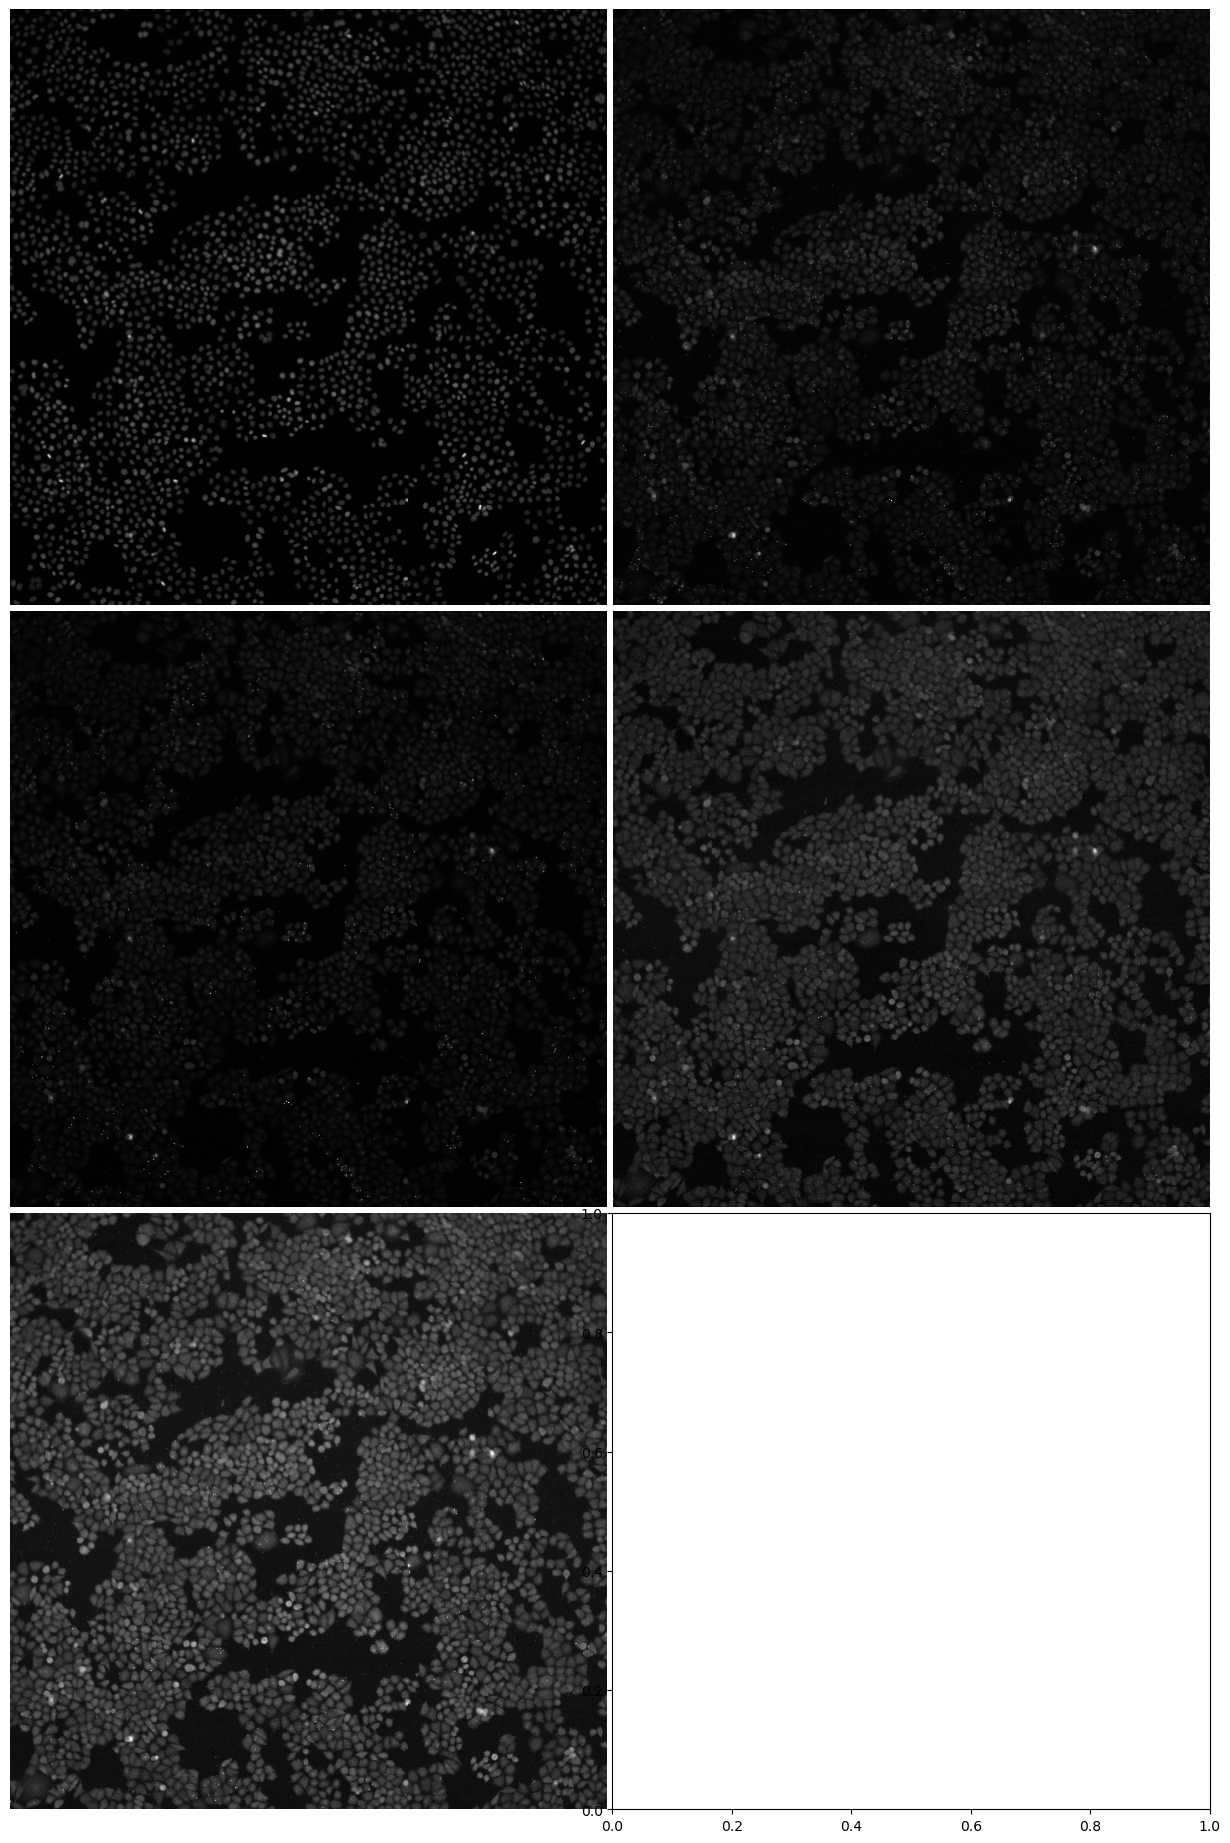

In [8]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        well=sbs_samples["well"][0],
        tile=sbs_samples["tile"][0],
        cycle=sbs_samples["tile"][0],
        channel_order=SBS_CHANNEL_ORDER,
    )

    # Convert test sbs sample to tiff
    sbs_image = nd2_to_tiff(sbs_sample, SBS_CHANNEL_ORDER_FLIP, verbose=True)
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()

### Test phenotype conversion

Processing file 1/1: data/phenotype/real_images/P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2
Original dimensions for data/phenotype/real_images/P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2: ('Z', 'C', 'Y', 'X')
Array shape after processing: (4, 2400, 2400)
Final dimensions (CYX): (4, 2400, 2400)
Converted phenotype test sample:


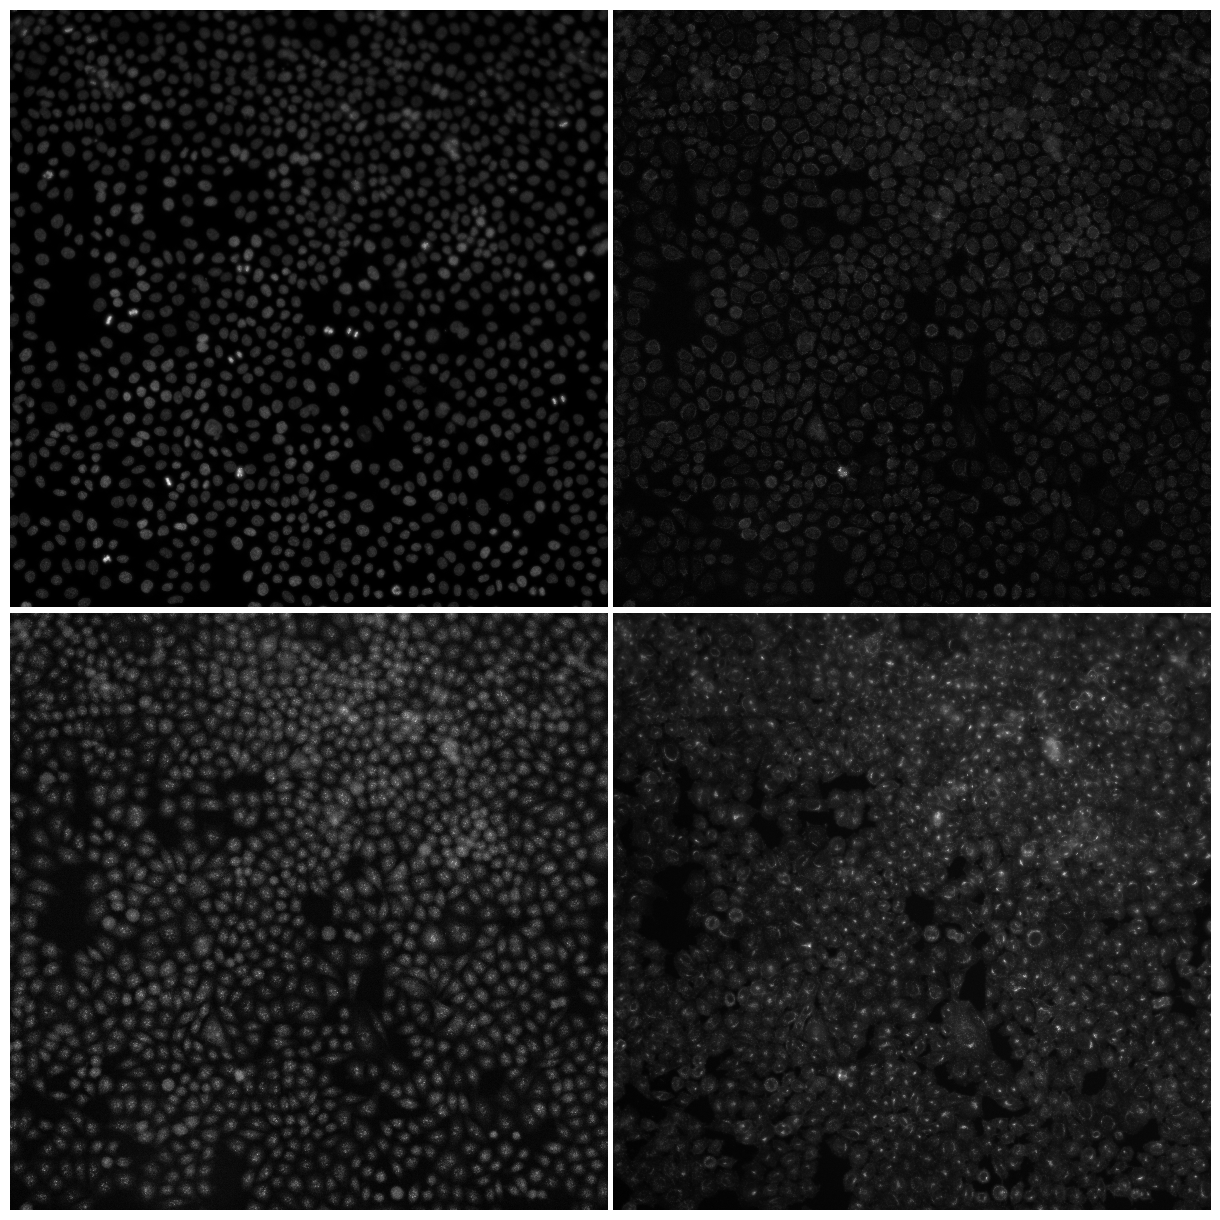

In [9]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        well=phenotype_samples["well"][0],
        tile=phenotype_samples["tile"][0],
        channel_order=PHENOTYPE_CHANNEL_ORDER,
    )
    # Convert test phenotype sample to tiff
    phenotype_image = nd2_to_tiff(
        phenotype_sample, PHENOTYPE_CHANNEL_ORDER_FLIP, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

## Create config file with params

In [10]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)